### How to run the experiments

1. Run the code below in this notebook until Section "SoftMax probabilities" to train and save the CNN.
2. Run `ae_training.py` to train AE. Change the number of epochs if needed.
3. Run `vae_training.py` to train VAE. Change the number of epochs if needed.
4. Run `calculate_sa.ipynb` to calculate SA prioritizations using the trained CNN as well as predictions made by the CNN. Change the path to the trained CNN if needed. The results are saved into `tmp` folder.
5. Run `calculate_sim.ipynb` to calculate similarity-based prioritizations and choose the best one. The results are saved into `tmp` folder.
6. Run `calculate_ae.ipynb` to calculate AE-based prioritization. Change the path to the trained AE if needed. The results are saved into `tmp` folder.
7. Run `calculate_vae.ipynb` to calculate VAE-based prioritization. Change the path to the trained VAE if needed. The results are saved into `tmp` folder. 
8. Run `calculate_fig.ipynb` to calculate the final figure using the results from `tmp` folder.

In [1]:
import os
import json

import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
CLIP_MIN = -0.5
CLIP_MAX = 0.5

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=os.path.expanduser('~/dev/data/mnist/mnist.npz'))

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train = (x_train / 255.0) - (1.0 - CLIP_MAX)
x_test = (x_test / 255.0) - (1.0 - CLIP_MAX)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Train the classifier

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense, UpSampling2D, Dropout, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model

In [24]:
layers = [
            Conv2D(64, (3, 3), padding="valid", input_shape=(28, 28, 1)),
            Activation("relu"),
            Conv2D(64, (3, 3)),
            Activation("relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.5),
            Flatten(),
            Dense(128),
            Activation("relu"),
            Dropout(0.5),
            Dense(10),
        ]

In [26]:
model = Sequential()
for layer in layers:
    model.add(layer)
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
activation_7 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0

In [32]:
model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

In [33]:
model.fit(x_train, y_train, epochs=50, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
469/469 [==============================] - 70s 149ms/step - loss: 2.3112 - accuracy: 0.1001 - val_loss: 2.3029 - val_accuracy: 0.1010
Epoch 2/50
469/469 [==============================] - 69s 146ms/step - loss: 2.3074 - accuracy: 0.1028 - val_loss: 2.3019 - val_accuracy: 0.1010
Epoch 3/50
469/469 [==============================] - 70s 149ms/step - loss: 2.3057 - accuracy: 0.1011 - val_loss: 2.3017 - val_accuracy: 0.1028
Epoch 4/50
469/469 [==============================] - 69s 147ms/step - loss: 2.3049 - accuracy: 0.1027 - val_loss: 2.3016 - val_accuracy: 0.1371
Epoch 5/50
469/469 [==============================] - 64s 137ms/step - loss: 2.3048 - accuracy: 0.1046 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 6/50
469/469 [==============================] - 64s 136ms/step - loss: 2.3042 - accuracy: 0.1052 - val_loss: 2.3016 - val_accuracy: 0.1135
Epoch 7/50
469/469 [==============================] - 64s 137ms/step - loss: 2.3038 - accuracy: 0.1057 - val_loss: 2.3016 - val_ac

In [34]:
model.save('./kim_cnn.h5')

### SoftMax probability

In [10]:
model = load_model('./models/model_01/model_mnist.h5')

OSError: SavedModel file does not exist at: ./models/model_mnist.h5/{saved_model.pbtxt|saved_model.pb}

In [10]:
softmax = model.predict(x_test)

In [21]:
softmax_prob = [1 - i.max() for i in softmax]

In [24]:
y_test_class_sorted = y_test_class[np.argsort(softmax_prob)]
y_pred_class_sorted = y_pred_class[np.argsort(softmax_prob)]

In [25]:
correct_preds = 0
cum_acc_asc = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_asc.append(correct_preds/(i+1))

In [28]:
y_test_class_sorted = y_test_class[np.argsort(softmax_prob)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(softmax_prob)[::-1]]

In [29]:
correct_preds = 0
cum_acc_dec = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_dec.append(correct_preds/(i+1))

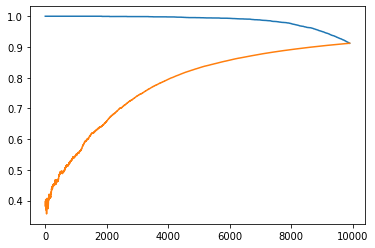

In [30]:
plt.plot(cum_acc_asc[100:])
plt.plot(cum_acc_dec[100:])
plt.show()

In [31]:
errors = 0
cum_errors_softmax = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] != y_pred_class_sorted[i]:
        errors += 1
    cum_errors_softmax.append(errors)

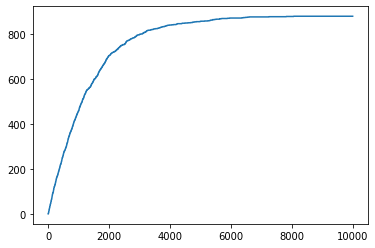

In [34]:
plt.plot(cum_errors_softmax)
plt.show()

### Calculate SA

In [8]:
from surprise_adequacy import SurpriseAdequacyConfig, DSA, LSA

In [9]:
config = SurpriseAdequacyConfig(saved_path='./tmp', is_classification=True, num_classes=10, 
                                layer_names=["activation_8"], ds_name="mnist")

In [10]:
sa = DSA(model=model, train_data=x_train, config=config)

In [11]:
sa.prep(use_cache=True)

Found saved train ATs, skip serving


In [ ]:
suprises, predictions = sa.calc(target_data=x_test, use_cache=False, ds_type='test')

Calculating the ats for test dataset
79/79 [==============================] - 2s 28ms/step
Layer: activation_8
[test] Saved the ats and predictions to ./tmp/mnist_test_activation_8_ats.npy and ./tmp/mnist_test_pred.npy
[test] Calculating DSA
[<class 'surprise_adequacy.DSA'>] Using 60000 train samples


### Read calculated SA

In [35]:
lsa_sadl = np.load('./results/lsa_sadl.npy')
dsa_sadl = np.load('./results/dsa_sadl.npy')

lsa_surprise_adequacy = np.load('./results/lsa_surprise_adequacy.npy')
dsa_surprise_adequacy = np.load('./results/dsa_surprise_adequacy.npy')

In [10]:
model = load_model('./models/model_01/model_mnist.h5')

In [11]:
y_pred = model.predict(x_test)

In [13]:
y_test_class = np.array([np.argmax(i) for i in y_test])
y_pred_class = np.array([np.argmax(i) for i in y_pred])

In [15]:
np.save('./models/model_01/predictions', y_pred_class)

In [50]:
y_test_class_sorted = y_test_class[np.argsort(dsa_sadl)]
y_pred_class_sorted = y_pred_class[np.argsort(dsa_sadl)]

In [51]:
correct_preds = 0
cum_acc_asc = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_asc.append(correct_preds/(i+1))

In [52]:
y_test_class_sorted = y_test_class[np.argsort(dsa_sadl)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(dsa_sadl)[::-1]]

In [53]:
correct_preds = 0
cum_acc_dec = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_dec.append(correct_preds/(i+1))

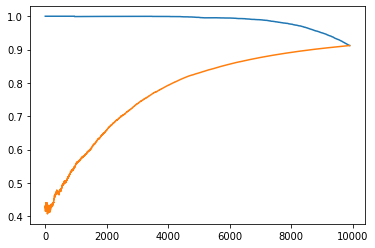

In [54]:
plt.plot(cum_acc_asc[100:])
plt.plot(cum_acc_dec[100:])
plt.show()

In [55]:
errors = 0
cum_errors_dsa = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] != y_pred_class_sorted[i]:
        errors += 1
    cum_errors_dsa.append(errors)

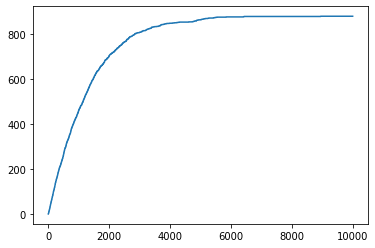

In [56]:
plt.plot(cum_errors_dsa)
plt.show()

### Loading the autoencoder

In [8]:
from models import model_01

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [9]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data(path=os.path.expanduser('~/dev/data/mnist/mnist.npz'))

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [11]:
autoencoder = model_01()
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)          

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
tb_callback = TensorBoard(log_dir='./tmp', profile_batch=0)
cp_callback = ModelCheckpoint('./tmp/checkpoint.h5', save_best_only=True)

In [14]:
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True,
                          validation_data=(x_test, x_test), callbacks=[tb_callback,cp_callback])

Epoch 1/50
469/469 [==============================] - 36s 76ms/step - loss: 0.2222 - val_loss: 0.1469
Epoch 2/50
 38/469 [=>............................] - ETA: 33s - loss: 0.1464

KeyboardInterrupt: 

In [ ]:
autoencoder.save('./tmp/autoencoder.h5')

In [ ]:
with open('./tmp/training_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
print("Training complete!")

### Autoencoder-based input prioritization

In [1]:
import os

import numpy as np

from sklearn.metrics import accuracy_score

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor, KernelDensity

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten

import matplotlib.pyplot as plt

In [17]:
autoencoder = load_model('./results/model_01/autoencoder.h5')

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [19]:
bottleneck = Model(autoencoder.input, autoencoder.get_layer(name='max_pooling2d_2').output)

gap_bottleneck = Sequential()
gap_bottleneck.add(bottleneck)
gap_bottleneck.add(GlobalAveragePooling2D())
# gap_bottleneck.add(Flatten())

gap_bottleneck.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 4, 4, 8)           1904      
_________________________________________________________________
global_average_pooling2d (Gl (None, 8)                 0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
_________________________________________________________________


In [20]:
(x_train, y_train), (x_test, y_test) = load_data(path=os.path.expanduser('~/dev/data/mnist/mnist.npz'))

In [21]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [31]:
%%timeit

decoded_imgs = autoencoder.predict(x_test)
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

1.76 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit

b_train = gap_bottleneck.predict(x_train)
b_test = gap_bottleneck.predict(x_test)

# estimator = KernelDensity(bandwidth=1.0)
estimator = LocalOutlierFactor(n_neighbors=20, novelty=True)
# estimator = OneClassSVM(degree=3)
# estimator = IsolationForest(n_estimators=100)
# estimator = EllipticEnvelope()

estimator.fit(b_train)

scores = -1 * estimator.score_samples(b_test)

5.71 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
bottleneck_values_prioritization = np.argsort(scores)[::-1]
reconstruction_errors_prioritization = np.argsort(reconstruction_errors)[::-1]

np.save('./results/model_01/bottleneck_values_prioritization.npy', bottleneck_values_prioritization)
np.save('./results/model_01/reconstruction_errors_prioritization.npy', reconstruction_errors_prioritization)

In [ ]:
y_test_class_sorted = y_test_class[np.argsort(reconstruction_errors)]
y_pred_class_sorted = y_pred_class[np.argsort(reconstruction_errors)]

In [68]:
y_test_class_sorted = y_test_class[np.argsort(scores)]
y_pred_class_sorted = y_pred_class[np.argsort(scores)]

In [69]:
correct_preds = 0
cum_acc_asc = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_asc.append(correct_preds/(i+1))

In [104]:
y_test_class_sorted = y_test_class[np.argsort(reconstruction_errors)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(reconstruction_errors)[::-1]]

In [70]:
y_test_class_sorted = y_test_class[np.argsort(scores)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(scores)[::-1]]

In [71]:
correct_preds = 0
cum_acc_dec = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] == y_pred_class_sorted[i]:
        correct_preds += 1
    cum_acc_dec.append(correct_preds/(i+1))

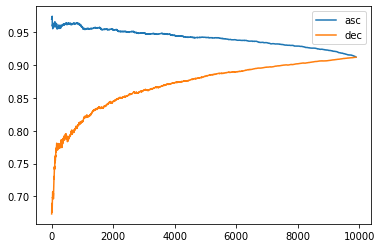

In [72]:
plt.plot(cum_acc_asc[100:], label='asc')
plt.plot(cum_acc_dec[100:], label='dec')
plt.legend()
plt.show()

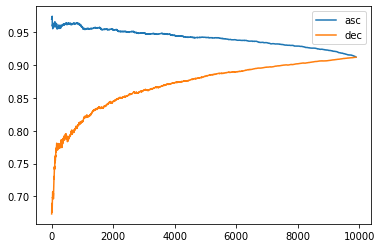

In [73]:
plt.plot(cum_acc_asc[100:], label='asc')
plt.plot(cum_acc_dec[100:], label='dec')
plt.legend()
plt.show()

In [74]:
errors = 0
cum_errors = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] != y_pred_class_sorted[i]:
        errors += 1
    cum_errors.append(errors)

In [16]:
autoencoder = load_model('./results/model_02/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test)
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

In [ ]:
y_test_class_sorted = y_test_class[np.argsort(reconstruction_errors)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(reconstruction_errors)[::-1]]

errors = 0
cum_errors_2 = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] != y_pred_class_sorted[i]:
        errors += 1
    cum_errors_2.append(errors)

In [17]:
bottleneck = Model(autoencoder.input, autoencoder.get_layer(name='max_pooling2d_1').output)

gap_bottleneck = Sequential()
gap_bottleneck.add(bottleneck)
gap_bottleneck.add(GlobalAveragePooling2D())
# gap_bottleneck.add(Flatten())

gap_bottleneck.summary()

b_train = gap_bottleneck.predict(x_train)
b_test = gap_bottleneck.predict(x_test)

# estimator = KernelDensity(bandwidth=1.0)
estimator = LocalOutlierFactor(n_neighbors=20, novelty=True)
# estimator = OneClassSVM(degree=3)
# estimator = IsolationForest(n_estimators=100)
# estimator = EllipticEnvelope()

estimator.fit(b_train)
scores = -1 * estimator.decision_function(b_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 7, 7, 32)          9568      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test_class_sorted = y_test_class[np.argsort(scores)[::-1]]
y_pred_class_sorted = y_pred_class[np.argsort(scores)[::-1]]

errors = 0
cum_errors_2 = []

for i in range(len(y_test_class_sorted)):
    if y_test_class_sorted[i] != y_pred_class_sorted[i]:
        errors += 1
    cum_errors_2.append(errors)

In [18]:
bottleneck_values_prioritization = np.argsort(scores)[::-1]
reconstruction_errors_prioritization = np.argsort(reconstruction_errors)[::-1]

np.save('./results/model_02/bottleneck_values_prioritization.npy', bottleneck_values_prioritization)
np.save('./results/model_02/reconstruction_errors_prioritization.npy', reconstruction_errors_prioritization)

In [76]:
ideal = list(range(errors)) + [errors] * (len(cum_errors)-errors)
random = [[0,len(cum_errors)], [0,errors]]

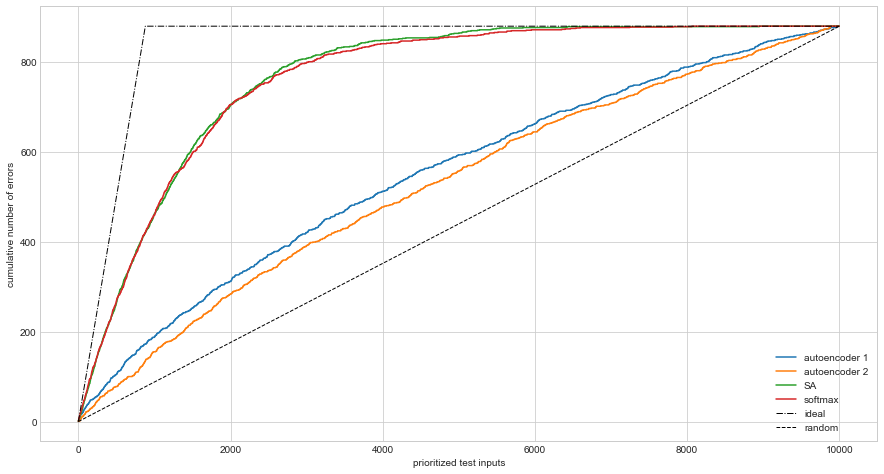

In [77]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,8))
    plt.plot(cum_errors, label='autoencoder 1')
    plt.plot(cum_errors_2, label='autoencoder 2')
    plt.plot(cum_errors_dsa, label='SA')
    plt.plot(cum_errors_softmax, label='softmax')
    plt.plot(ideal, '-.', c='k', linewidth=1, label='ideal')
    plt.plot(*random, '--', c='k', linewidth=1, label='random')
    plt.xlabel('prioritized test inputs')
    plt.ylabel('cumulative number of errors')
    plt.legend()
#     plt.savefig(os.path.expanduser('~/Desktop/result.png'), dpi=300, bbox_inches='tight')
    plt.show()

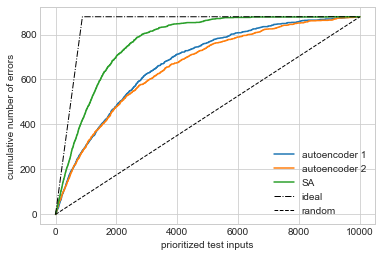

In [89]:
with plt.style.context('seaborn-whitegrid'):
    plt.plot(cum_errors, label='autoencoder 1')
    plt.plot(cum_errors_2, label='autoencoder 2')
    plt.plot(cum_errors_dsa, label='SA')
    plt.plot(ideal, '-.', c='k', linewidth=1, label='ideal')
    plt.plot(*random, '--', c='k', linewidth=1, label='random')
    plt.xlabel('prioritized test inputs')
    plt.ylabel('cumulative number of errors')
    plt.legend()
    plt.savefig(os.path.expanduser('~/Desktop/result.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [47]:
accuracy_score(y_test_class, y_pred_class)

0.9121

### Plot the distributions

In [1]:
import os
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.mnist import load_data as load_mnist
from tensorflow.keras.datasets.fashion_mnist import load_data as load_fashion
from tensorflow.keras.datasets.cifar10 import load_data as load_cifar

import tensorflow_datasets as tfds

from vae import Sampling, VAE

import matplotlib.pyplot as plt

#### MNIST

In [2]:
(_, _), (x_test, _) = load_mnist(path=os.path.expanduser('~/dev/data/mnist/mnist.npz'))

x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [3]:
autoencoder = load_model('../mnist/results/model_01/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test)
re_ae_mnist = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('../mnist/results/model_04/vae_weights')

z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
re_vae_mnist = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

#### Fashion-MNIST

In [26]:
(_, _), (x_test, _) = load_fashion()

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1)

In [27]:
autoencoder = load_model('../fashion_mnist/results/model_01/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test)
re_ae_fashion = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

In [28]:
latent_dim = 2 # 16

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x) # 32
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('../fashion_mnist/results/model_02/vae_weights')

z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
re_vae_fashion = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

#### CIFAR-10

In [16]:
(_, _), (x_test, _) = load_cifar()

x_test = x_test.astype('float32') / 255.

In [17]:
autoencoder = load_model('../cifar/results/model_05/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test)
re_ae_cifar = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

In [18]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('../cifar/results/model_04/vae_weights')

z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
re_vae_cifar = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

#### STL-10

In [19]:
(x_test, _) = tfds.as_numpy(tfds.load('stl10', split='test', batch_size=-1, as_supervised=True))

x_test = x_test.astype('float32') / 255.

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [20]:
autoencoder = load_model('../stl10/results/model_01/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test)
re_ae_stl = np.mean(np.square(x_test - decoded_imgs), axis=(3,1,2))

In [21]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(96, 96, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(12 * 12 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((12, 12, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('../stl10/results/model_02/vae_weights')

z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
re_vae_stl = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

#### Figure

In [22]:
TITLES = [
    'AE MNIST', 
    'AE Fashion-MNIST', 
    'AE CIFAR-10', 
    'AE STL-10', 
    'VAE MNIST', 
    'VAE Fashion-MNIST', 
    'VAE CIFAR-10', 
    'VAE STL-10',
]

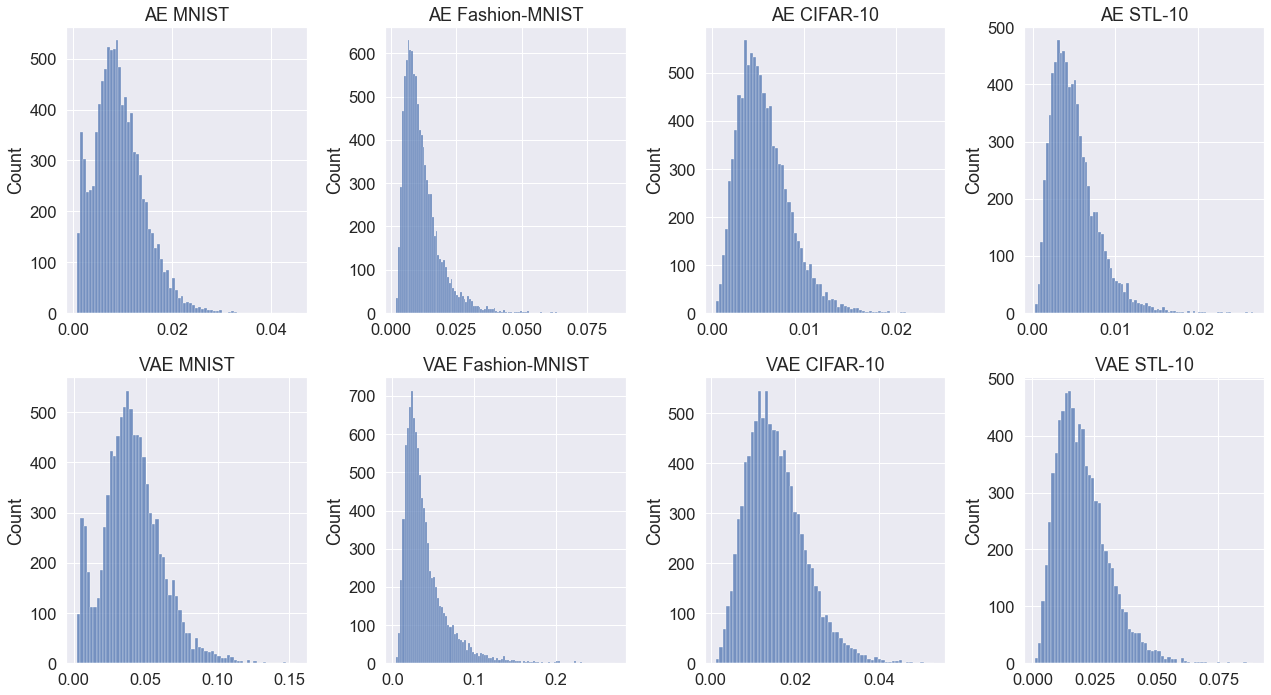

In [29]:
plt.figure(figsize=(18,10))
sns.set(font_scale=1.5)
for i, (data, title) in enumerate(zip([
    re_ae_mnist, re_ae_fashion, re_ae_cifar, re_ae_stl, re_vae_mnist, re_vae_fashion, re_vae_cifar, re_vae_stl
], TITLES)):
    plt.subplot(2,4,i+1)
    sns.histplot(data)
    plt.title(title)
plt.tight_layout()
plt.savefig('/Users/vmosin/Desktop/distributions.png')
plt.show()